# Model comparison: Baseline CNN vs ResNet

This notebook loads the saved checkpoints for the baseline model and the ResNet model, evaluates both on the `data/face/test` set, and compares:
- Accuracy and macro F1
- Confusion matrices side-by-side
- Training curves (if available)
- Inference latency (average per image)

Notes: run this notebook from the repository root so relative paths (e.g., `data/face/test`) resolve correctly. If imports from `src` fail, ensure `sys.path` includes the repo root (the notebook will try to add it).

In [21]:
# Standard imports
import sys, os
from pathlib import Path
import time
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
sns.set(style='whitegrid')

# Make sure repo root is importable
repo_root = Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
print('Repo root in sys.path:', sys.path[0])

Repo root in sys.path: /Users/owner/Documents/news-bias-detection


In [22]:
# Paths and device
DATA_ROOT = Path('..') / 'data' / 'face'
TEST_DIR = DATA_ROOT / 'test'
CHECKPOINT_DIR = Path('..') / 'models' / 'checkpoints'
# Use the requested baseline checkpoint from the sgd_nesterov_amp_run folder
BASELINE_CKPT = CHECKPOINT_DIR / 'sgd_nesterov_amp_run' / 'best_baseline.pt'
RESNET_CKPT = CHECKPOINT_DIR / 'best_resnet.pt'
print('Test dir:', TEST_DIR.resolve())
print('Baseline ckpt:', BASELINE_CKPT.exists(), '->', BASELINE_CKPT)
print('ResNet ckpt:', RESNET_CKPT.exists(), '->', RESNET_CKPT)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Test dir: /Users/owner/Documents/news-bias-detection/data/face/test
Baseline ckpt: True -> ../models/checkpoints/sgd_nesterov_amp_run/best_baseline.pt
ResNet ckpt: True -> ../models/checkpoints/best_resnet.pt


device(type='cpu')

In [23]:
# Build preprocessing transform — must match the training pipeline (ImageNet norm)
IMG_SIZE = 224
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test dataset with ImageFolder (class order determined by folder names)
test_dataset = ImageFolder(root=str(TEST_DIR), transform=preprocess)
class_names = test_dataset.classes
num_classes = len(class_names)
print('Classes found:', class_names)
print('Num classes:', num_classes)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Classes found: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Num classes: 7


In [24]:
# Try importing model classes from src, with fallbacks if import fails
ModelConstructors = {}
try:
    # The repository's ResNet wrapper class is named EmotionResNet — alias it to ResNetEmotion
    from src.models.resnet_emotion import EmotionResNet as ResNetEmotion
    from src.models.baseline_cnn import BaselineCNN
    ModelConstructors['resnet'] = ResNetEmotion
    ModelConstructors['baseline'] = BaselineCNN
    print('Imported ResNetEmotion (aliased from EmotionResNet) and BaselineCNN from src.models')
except Exception as e:
    print('Could not import model constructors from src.models — you may need to adjust imports:', e)
    # Define minimal lightweight fallbacks if needed (very small networks)
    try:
        import torch.nn as nn
        class BaselineCNN(nn.Module):
            def __init__(self, num_classes=6):
                super().__init__()
                self.net = nn.Sequential(
                    nn.Conv2d(3,16,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
                    nn.Conv2d(16,32,3,padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1),
                    nn.Flatten(), nn.Linear(32, num_classes)
                )
            def forward(self,x):
                return self.net(x)
        class ResNetDummy(nn.Module):
            def __init__(self, num_classes=6):
                super().__init__()
                self.head = nn.Linear(512, num_classes)
            def forward(self, x):
                x = torch.flatten(x,1)
                return self.head(x)
        ModelConstructors['baseline'] = BaselineCNN
        ModelConstructors['resnet'] = ResNetDummy
        print('Using fallback simple model constructors — these are only placeholders for interface compatibility.')
    except Exception as e2:
        print('Fallback model constructors failed:', e2)

Imported ResNetEmotion (aliased from EmotionResNet) and BaselineCNN from src.models


In [26]:
# Helper to load a checkpoint into a model instance (robust to state dict prefixes and shape mismatches)
import torch

def load_checkpoint(model, checkpoint_path, map_location='cpu'):
    """Load checkpoint into model while skipping parameters that don't match in name or shape.

    Returns: (model, skipped_keys)
    - skipped_keys: list of tuples (key, ckpt_shape, model_shape) for parameters that were present in the
      checkpoint but were not loaded due to shape/name mismatch.
    """
    ckpt = torch.load(str(checkpoint_path), map_location=map_location)
    # Common wrappers
    if isinstance(ckpt, dict):
        for key in ("state_dict", "model_state_dict", "model", "net"):
            if key in ckpt and isinstance(ckpt[key], dict):
                state = ckpt[key]
                break
        else:
            state = ckpt
    else:
        state = ckpt

    # Normalize keys: remove 'module.' prefix if present
    normalized = {}
    for k, v in state.items():
        new_k = k.replace('module.', '') if isinstance(k, str) else k
        normalized[new_k] = v

    model_state = model.state_dict()
    to_load = {}
    skipped = []

    for k, v in normalized.items():
        if k in model_state:
            try:
                # v may be a numpy array or Tensor; ensure we compare shapes safely
                v_shape = tuple(v.shape) if hasattr(v, 'shape') else None
                m_shape = tuple(model_state[k].shape) if hasattr(model_state[k], 'shape') else None
                if v_shape == m_shape:
                    to_load[k] = v
                else:
                    skipped.append((k, v_shape, m_shape))
            except Exception:
                skipped.append((k, None, tuple(model_state[k].shape) if hasattr(model_state[k], 'shape') else None))
        else:
            # key from checkpoint not present in model
            skipped.append((k, tuple(v.shape) if hasattr(v, 'shape') else None, None))

    # Load the compatible subset
    model.load_state_dict(to_load, strict=False)

    if skipped:
        print(f"Skipped {len(skipped)} parameter(s) due to name/shape mismatch. Example skipped keys:")
        for ex in skipped[:10]:
            print('  ', ex)
    else:
        print('All checkpoint parameters matched and were loaded (where names present).')

    return model, skipped


# Instantiate models and load checkpoints when available
models = {}
try:
    baseline_model = ModelConstructors['baseline'](num_classes=num_classes)
    baseline_model = baseline_model.to(device)
    if BASELINE_CKPT.exists():
        baseline_model, skipped_baseline = load_checkpoint(baseline_model, BASELINE_CKPT, map_location=device)
        if skipped_baseline:
            print(f'Baseline checkpoint partially loaded: {len(skipped_baseline)} keys skipped (see summary above).')
        else:
            print('Loaded baseline checkpoint (full match).')
    models['baseline'] = baseline_model
except Exception as e:
    print('Failed to prepare baseline model:', e)

try:
    resnet_model = ModelConstructors['resnet'](num_classes=num_classes)
    resnet_model = resnet_model.to(device)
    if RESNET_CKPT.exists():
        resnet_model, skipped_resnet = load_checkpoint(resnet_model, RESNET_CKPT, map_location=device)
        if skipped_resnet:
            print(f'ResNet checkpoint partially loaded: {len(skipped_resnet)} keys skipped.')
        else:
            print('Loaded resnet checkpoint (full match).')
    models['resnet'] = resnet_model
except Exception as e:
    print('Failed to prepare resnet model:', e)


All checkpoint parameters matched and were loaded (where names present).
Loaded baseline checkpoint (full match).
All checkpoint parameters matched and were loaded (where names present).
Loaded resnet checkpoint (full match).


In [27]:
# Evaluation function: returns y_true, y_pred (numpy arrays)
@torch.no_grad()
def evaluate_model(model, dataloader, device):
    model.eval()
    ys = []
    yps = []
    for xb, yb in dataloader:
        xb = xb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        ys.append(yb.numpy())
        yps.append(preds)
    y_true = np.concatenate(ys) if ys else np.array([])
    y_pred = np.concatenate(yps) if yps else np.array([])
    return y_true, y_pred

results = {}
for name, mdl in models.items():
    print('Evaluating', name)
    try:
        y_true, y_pred = evaluate_model(mdl, test_loader, device)
        results[name] = {'y_true': y_true, 'y_pred': y_pred}
        print(f'{name} done — {len(y_true)} samples')
    except Exception as e:
        print('Evaluation failed for', name, e)

Evaluating baseline
baseline done — 7178 samples
Evaluating resnet
resnet done — 7178 samples


In [28]:
# Compute metrics and confusion matrices, and plot side-by-side
def summarize_results(results_dict, class_names):
    summary = {}
    for name, d in results_dict.items():
        y_true = d.get('y_true')
        y_pred = d.get('y_pred')
        if y_true is None or len(y_true)==0:
            summary[name] = None
            continue
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
        summary[name] = {'accuracy': acc, 'macro_f1': f1, 'confusion_matrix': cm}
    return summary

summary = summarize_results(results, class_names)
summary

{'baseline': {'accuracy': 0.21677347450543327,
  'macro_f1': 0.18009834536502994,
  'confusion_matrix': array([[146, 170,   3,  65, 234,  81, 259],
         [ 15,  29,   0,   9,  25,   5,  28],
         [104, 209,  11,  45, 214,  58, 383],
         [168, 338,  16, 265, 516,  96, 375],
         [120, 250,  10,  74, 476,  76, 227],
         [146, 206,  17, 124, 413, 133, 208],
         [ 34, 155,  10,  12, 111,  13, 496]])},
 'resnet': {'accuracy': 0.6624407913067707,
  'macro_f1': 0.6414573872360877,
  'confusion_matrix': array([[ 585,   37,   68,   31,  101,  111,   25],
         [  16,   79,    1,    3,    3,    8,    1],
         [ 160,    8,  419,   24,   96,  205,  112],
         [  42,    1,   25, 1495,  105,   39,   67],
         [  84,    1,   58,   66,  825,  167,   32],
         [ 119,   12,  122,   38,  263,  663,   30],
         [  33,    2,   59,   17,   13,   18,  689]])}}

,accuracy,macro_f1
model,,
baseline,0.216773,0.180098
resnet,0.662441,0.641457


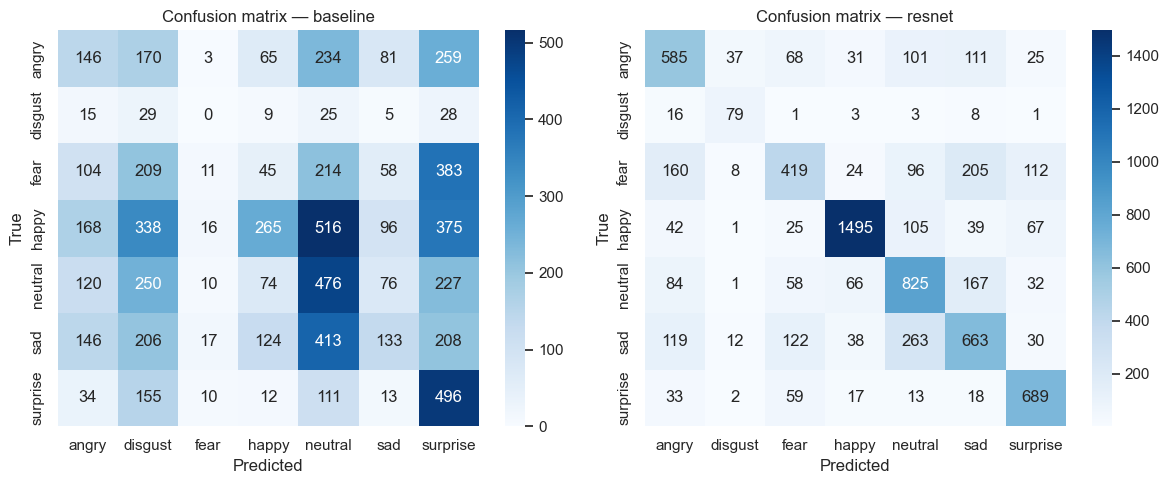

In [32]:
# Pretty-print metrics and plot confusion matrices
valid_summaries = {k:v for k,v in summary.items() if v is not None}
if not valid_summaries:
    print('No valid evaluation results to display — ensure models loaded and test dataset is non-empty.')
else:
    # Metrics table
    rows = []
    for name, vals in valid_summaries.items():
        rows.append({'model': name, 'accuracy': vals['accuracy'], 'macro_f1': vals['macro_f1']})
    # IPython.display was imported as a module named `display` in another cell,
    # so call the display function via display.display(...)
    display.display(pd.DataFrame(rows).set_index('model'))

    # Confusion matrices side-by-side
    n = len(valid_summaries)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))
    if n == 1:
        axes = [axes]
    for ax, (name, vals) in zip(axes, valid_summaries.items()):
        cm = vals['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=class_names, yticklabels=class_names)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'Confusion matrix — {name}')
    plt.tight_layout()
    plt.show()

Displaying baseline image: baseline_training_curves.png


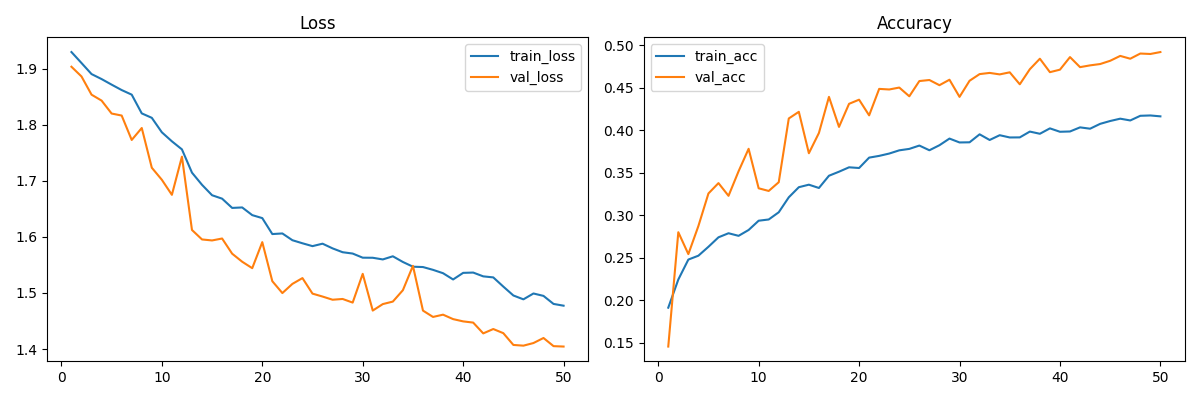

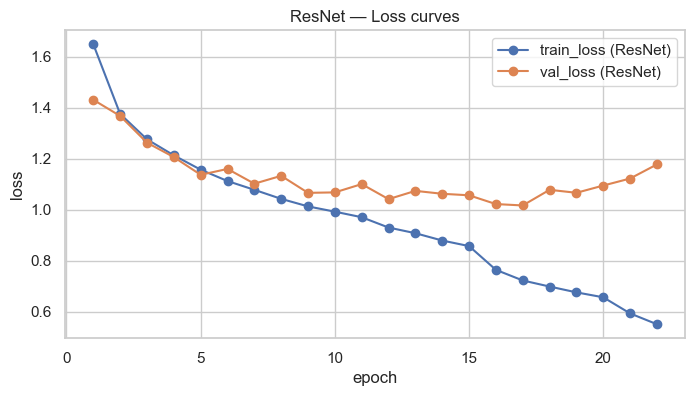

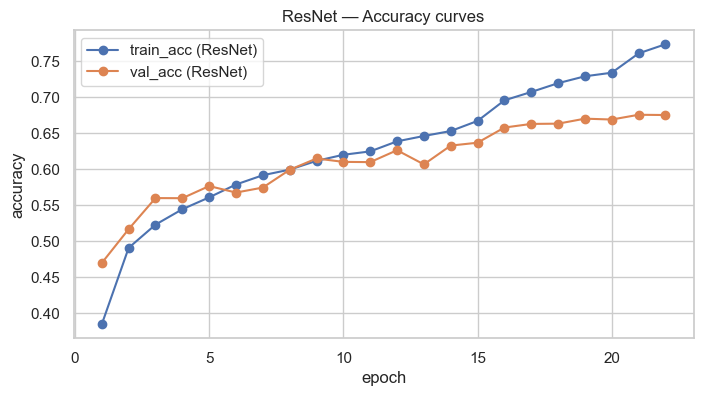

In [39]:
from IPython import display as _display

# Display baseline-specific training curve (if present) and any other training-curve images (e.g., resnet)

# Prefer the baseline-specific image
if 'baseline_curve' in globals() and baseline_curve.exists():
    print('Displaying baseline image:', baseline_curve.name)
    _display.display(_display.Image(str(baseline_curve)))
else:
    # look for other training-curve images under CHECKPOINT_DIR
    others = list(CHECKPOINT_DIR.glob('*training*curve*.png')) + list(CHECKPOINT_DIR.glob('*training*curves*.png'))
    shown = False
    for p in others:
        if p.exists():
            label = 'ResNet training curves' if 'resnet' in p.name.lower() else 'Training curves'
            print(f'Displaying {label}:', p.name)
            _display.display(_display.Image(str(p)))
            shown = True
            break
    if not shown:
        print('No training-curve image found in checkpoint dir.')

# Use existing dataframe if available; prefer dfm/df_metrics already in notebook
if 'dfm' in globals():
    df_metrics = dfm
elif 'df_metrics' in globals():
    df_metrics = df_metrics
else:
    # fallback to reading metrics_csv if it exists
    try:
        if metrics_csv.exists():
            df_metrics = pd.read_csv(metrics_csv)
        else:
            df_metrics = None
    except Exception as e:
        print('Failed to load metrics CSV:', e)
        df_metrics = None

# Plot metrics dataframe (label explicitly as "Baseline" since the CSV corresponds to the baseline run)
if df_metrics is not None and 'epoch' in df_metrics.columns:
    # Loss curves (Baseline)
    plt.figure(figsize=(8,4))
    plotted = False
    if 'train_loss' in df_metrics.columns:
        plt.plot(df_metrics['epoch'], df_metrics['train_loss'], label='train_loss (ResNet)', marker='o')
        plotted = True
    if 'val_loss' in df_metrics.columns:
        plt.plot(df_metrics['epoch'], df_metrics['val_loss'], label='val_loss (ResNet)', marker='o')
        plotted = True
    if plotted:
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.title('ResNet — Loss curves')
        plt.grid(True)
        plt.show()

    # Accuracy curves (Baseline)
    plt.figure(figsize=(8,4))
    plotted = False
    if 'train_acc' in df_metrics.columns:
        plt.plot(df_metrics['epoch'], df_metrics['train_acc'], label='train_acc (ResNet)', marker='o')
        plotted = True
    if 'val_acc' in df_metrics.columns:
        plt.plot(df_metrics['epoch'], df_metrics['val_acc'], label='val_acc (ResNet)', marker='o')
        plotted = True
    if plotted:
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend()
        plt.title('ResNet — Accuracy curves')
        plt.grid(True)
        plt.show()
else:
    print('No metrics dataframe available for plotting.')

In [19]:
# Measure inference latency (average per image) for each model — using a small sample from test set
def measure_latency(model, dataset, device, n_samples=100):
    model.eval()
    loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)
    times = []
    it = iter(loader)
    with torch.no_grad():
        for i in range(min(n_samples, len(dataset))):
            try:
                x, _ = next(it)
            except StopIteration:
                break
            x = x.to(device)
            t0 = time.time()
            _ = model(x)
            t1 = time.time()
            times.append(t1-t0)
    return np.mean(times), np.std(times)

latencies = {}
for name, mdl in models.items():
    try:
        mean_t, std_t = measure_latency(mdl, test_dataset, device, n_samples=50)
        latencies[name] = (mean_t, std_t)
        print(f'{name}: mean={mean_t*1000:.2f} ms, std={std_t*1000:.2f} ms')
    except Exception as e:
        print('Latency measurement failed for', name, e)
latencies

baseline: mean=47.63 ms, std=6.66 ms
resnet: mean=14.90 ms, std=18.76 ms
resnet: mean=14.90 ms, std=18.76 ms


baseline: mean=47.63 ms, std=6.66 ms
resnet: mean=14.90 ms, std=18.76 ms
resnet: mean=14.90 ms, std=18.76 ms


{'baseline': (np.float64(0.04762691020965576),
  np.float64(0.006658412731848581)),
 'resnet': (np.float64(0.01490288257598877), np.float64(0.018756826226038872))}

## Conclusion / next steps
From the metrics and confusion matrices, we can conclude that the improvement in the ResNet model justifies the additional training cost.